# Cyclic Coordinate Descent for Logistic Regression with Lasso regularization

This notebook presents the implementation of Cyclic Coordinate Descent (CCD) algorithm for parameter 
estimation in regularized logistic regression with l1 (lasso) penalty and compares it with standard 
logistic regression model without regularization. 

## Imports & Consts

In [1]:
import os
from scipy.io import arff
import numpy as np
import pandas as pd
from typing import List
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
)
import matplotlib.pyplot as plt
import seaborn as sns
import gc

sns.set_theme(style="whitegrid", palette="cubehelix")

In [2]:
CONST_DATASET_DIRECTORY_PATH = "./datasets"
CONST_RESULTS_DIRECTORY_PATH = "./results"

In [3]:
# Ensure reproducibility (More details in the README.md)
CONST_RANDOM_SEED = 42
np.random.seed(CONST_RANDOM_SEED)

## Data preprocessing

TODO: Find 4 datasets

In [4]:
def load_datasets() -> List[dict[str, pd.DataFrame]]:
    """Load all ARFF datasets from the datasets folder and return them as a list of polars dataframes."""
    datasets = []
    for file in os.listdir(CONST_DATASET_DIRECTORY_PATH):
        if file.endswith(".arff"):
            data = arff.loadarff(f"{CONST_DATASET_DIRECTORY_PATH}/{file}")
            df = pd.DataFrame(data[0])
            datasets.append({"name": file.strip(".arff"), "data": df})
    return datasets


def load_dataset(path: str) -> pd.DataFrame:
    """Load a dataset from a given path and return it as a polars dataframe."""
    data = arff.loadarff(path)
    return pd.DataFrame(data[0])

In [5]:
class Dataset:
    """Represents the dataset with the name, features, target, and preprocessing steps.
    Features and target are available as numpy arrays after preprocessing.
    """

    def __init__(
        self, name: str, df: pd.DataFrame, preprocessing_steps: List[callable] = None
    ):
        """Initialize a new dataset with a name, data, and preprocess the data resulting in two numpy arrays. X - features, and y - target."""

        self.name = name
        self.preprocessing_steps = preprocessing_steps

        self.X = df[df.columns[:-1]]
        self.y = df[df.columns[-1]]

        for step in self.preprocessing_steps:
            self.X = step(self.X)

        # Improve Logistic Regression performance by converting to numpy arrays
        self.X = self.X.to_numpy()

        # Convert the target to binary values
        self.class_names = self.y.unique()

        # To mitigate CopyOnWriteWarning
        self.y = self.y.copy()

        indexes_0 = np.where(self.y == self.class_names[0])
        indexes_1 = np.where(self.y == self.class_names[1])

        self.y[indexes_0] = 0
        self.y[indexes_1] = 1
        self.y = self.y.to_numpy()

    def fill_missing_values(df: pd.DataFrame) -> pd.DataFrame:
        """Fill the missing values in the dataframe using the mean of the column strategy."""
        return df.fillna(df.mean())

    def remove_colinear_features(
        df: pd.DataFrame, threshold: float = 0.8
    ) -> pd.DataFrame:
        """Remove features of a dataframe that are colinear."""

        corr_matrix = df.corr().abs()

        upper_tri = corr_matrix.where(
            np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
        )

        to_drop = [
            column for column in upper_tri.columns if any(upper_tri[column] > threshold)
        ]

        return df.drop(columns=to_drop)

    def normalize(df: pd.DataFrame) -> pd.DataFrame:
        """Normalize the features of a dataframe based on Min-Max."""

        # Use the Min-Max normalization to produce features in range [0, 1]

        return (df - df.min()) / (df.max() - df.min())


class APBreastKidney(Dataset):
    """APBreastKidney dataset.
    source: https://www.openml.org/search?type=data&sort=runs&id=1158&status=active
    """

    dataset_path = f"{CONST_DATASET_DIRECTORY_PATH}/AP_Breast_Kidney.arff"

    def __init__(self):
        """Initialize tha APBreastKidney dataset"""

        data = load_dataset(APBreastKidney.dataset_path)

        super().__init__(
            "APBreastKidney",
            data,
            [
                Dataset.fill_missing_values,
                Dataset.remove_colinear_features,
                Dataset.normalize,
            ],
        )


class SyntheticDataset(Dataset):

    def __init__(self, p=0.5, n=1000, d=10, g=0.1):
        """Initialize the synthetic dataset with the given parameters."""

        # Generate binary class variable (Y=0 or Y=1) from Bernoulli distribution with class prior probability p.

        y = np.random.binomial(1, p, n)

        # Generate feature vector X, such that X|Y=0 follows d-dimensional multivariate normal distribution with mean (0,…,0) and covariance matrix S with 𝑆[ⅈ,𝑗] = 𝑔^|ⅈ−𝑗| , whereas X|Y=1 follows d-dimensional multivariate normal distribution with mean (1,1/2,1/3,…1/d) and covariance matrix 𝑆[ⅈ, 𝑗] = 𝑔^|ⅈ−𝑗|.

        X = np.zeros((n, d))

        X[y == 0] = np.random.multivariate_normal(
            np.zeros(d),  # mean
            np.array(
                [[np.pow(g, np.abs(i - j)) for i in range(d)] for j in range(d)]
            ),  # covariance matrix
            sum(y == 0),  # number of samples for class 0
        )
        X[y == 1] = np.random.multivariate_normal(
            np.array([1 / (i + 1) for i in range(d)]),  # mean
            np.array(
                [[np.pow(g, np.abs(i - j)) for i in range(d)] for j in range(d)]
            ),  # covariance matrix
            sum(y == 1),  # number of samples for class 1
        )

        # Concatenate the features and target to a single dataframe
        data = np.concatenate((X, y.reshape(-1, 1)), axis=1)
        data = pd.DataFrame(data)

        super().__init__(
            "SyntheticDataset",
            data,
            [
                Dataset.normalize,
            ],
        )

In [6]:
%%time
# Keep in mind removing colinear features on a dataset with couple thousands of them is relatively time consuming

# datasets = [APBreastKidney()]

CPU times: total: 0 ns
Wall time: 12.2 μs


In [7]:
%%time

# Alternatively, load all ARFF datasets from the datasets folder
# As a result you will obtain a list Datasets objects

# datasets = load_datasets()

# preprocessing_steps = [
#     Dataset.fill_missing_values,
#     Dataset.remove_colinear_features,
#     Dataset.normalize,
# ]

# for i in range(len(datasets)):
#     datasets[i] = Dataset(datasets[i]["name"], datasets[i]["data"], preprocessing_steps)

CPU times: total: 0 ns
Wall time: 13.4 μs


## LogRegCCD

Implementation of regularized Logistic Regression with Cyclic Coordinate Descent based on the [publication](https://www.jstatsoft.org/article/view/v033i01) (Chapter 3 is most relevant).

### Logistic Regression

Logistic Regression is a machine learning method capable of binary classification. It predicts the probability of an outcome. Its steps are as follows:

Compute a linear combination of input features:

$$
z = w_0 + w_1 x_1 + w_2 x_2 + \dots + w_n x_n = \mathbf{w}^T \mathbf{x} + b
$$

Where:
- $x$ denotes input feature vector, where $x_1,...,x_n$ are the elements of that vector
- $w$ denotes model weights vector 
- $b$ is the bias term  

The output $z$ is then provided to the sigmoid function:

$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$

The output in range [0,1] denotes the probability that given feature vector $x$ belongs to the positive class.

Prediction rule is based on the output of the sigmoid function, if it's larger than 0.5 we assign to class 1, otherwise assign to class 0.

To fit the model to the training data. One needs to minimize the loss function, in this case Binary Cross-Entropy:

$$
\mathcal{L} = -\frac{1}{m} \sum_{i=1}^{m} \left[ y^{(i)} \log \hat{y}^{(i)} + \left(1 - y^{(i)}\right) \log \left(1 - \hat{y}^{(i)}\right) \right]
$$

Where:
- $m$ denotes the number of training examples  
- $y^{(i)}$ is the class label 
- $\hat{y}^{(i)}$ is the predicted probability  


The weights of the model need to be optimized to find the proper fit, this can be achieved by standard gradient descent:

$$
w_j := w_j - \alpha \frac{\partial \mathcal{L}}{\partial w_j}
$$

$$
b := b - \alpha \frac{\partial \mathcal{L}}{\partial b}
$$

Where:
- $\alpha$ is the learning rate, the higher the value the more aggressive weight updates  
- $\frac{\partial \mathcal{L}}{\partial w_j}$ is a gradient with respect to weight $w_j$


Lasso Regulaization is used to prevent overfitting, when the trained model can predict samples from the training set very well but struggles on the test set.

Then the loss function becomes:

$$
\mathcal{L}_{\text{lasso}} = -\frac{1}{m} \sum_{i=1}^{m} \left[ y^{(i)} \log \hat{y}^{(i)} + \left(1 - y^{(i)}\right) \log \left(1 - \hat{y}^{(i)}\right) \right] + \lambda \sum_{j=1}^{n} |w_j|
$$

Where:
- $m$  is the number of training samples  
- $y^{(i)}$ is the class label
- $\hat{y}^{(i)}$ is the predicted probability 
- $\lambda$ denotes regularization strength 

In essence during the training process, the model will also minizem the absolute sum of the coefficients in addition to the loss function

Now, to use the Cyclic Coordinate Descent instead of the standard Gradient Descent one needs to minimize the $\mathcal{L}_{\text{lasso}}$ using a different algorithm for updating model weights.

However the authors of the [publication](https://www.jstatsoft.org/article/view/v033i01) present a more sophisticated approach with certain optimizations so let us focus on them first.

First, the Logistic Regression log-likelihood:

$$
\max_{\beta} \sum_{i=1}^{N} \left[ y_i \log(p_i) + (1 - y_i) \log(1 - p_i) \right] - \lambda ||\beta||_1
$$

is approximated with a quadratic approximation:

$$
\ell_Q(\beta_0, \beta) = -\frac{1}{2N} \sum_{i=1}^{N} w_i (z_i - \beta_0 - x_i^T \beta)^2 + C
$$

That converts the problem into a penalized weighted least squares.

The authors also use a regularization path that starts from largest $\lambda$ where $\beta = 0$ and decreases $\lambda$ gradually, using previous solutions as warm starts.

Instead of computing gradients from scratch with each iteration, the authors propose to use covariance updates:

$$
\sum_{i=1}^{N} x_{ij} r_i = \langle x_j, y \rangle - \sum_{k: \beta_k \neq 0} \langle x_j, x_k \rangle \beta_k
$$

For each feature $j$, the optimization problem simplifies to:

$$
\min_{\beta_j} \left[ \frac{1}{2} \sum_{i=1}^{N} w_i \left( z_i - \beta_0 - \sum_{k \neq j} x_{ik} \beta_k - x_{ij} \beta_j \right)^2 + \lambda |\beta_j| \right]
$$

To update the weights using CCD one needs to (for weight j):
1. Compute partial residuals (excluding $\beta_j$):

   $$
   r_i = z_i - (\beta_0 + \sum_{k \neq j} x_{ik} \beta_k)
   $$

2. Compute the gradient component $\rho_j$:

   $$
   \rho_j = \sum_{i=1}^{N} w_i x_{ij} r_i
   $$

3. Apply soft-thresholding for L1 regularization:

   $$
   \beta_j = \frac{S(\rho_j, \lambda)}{\sum_{i=1}^{N} w_i x_{ij}^2}
   $$

   where the soft-thresholding operator is:

   $$
   S(z, \lambda) = \text{sign}(z) \cdot \max(|z| - \lambda, 0)
   $$

And then $\beta_0$ that is not regularized:
$$
\beta_0 = \frac{\sum_{i=1}^{N} w_i (z_i - x_i^T \beta)}{\sum_{i=1}^{N} w_i}
$$


From a high level overview the presented algorithm consists of:

1. Outer Loop:
   - Decrease $\lambda$ along a regularization path.

2. Middle Loop:
   - Update the quadratic approximation using the current $(\beta_0, \beta)$.

3. Inner Loop:
   - Perform coordinate descent on the penalized weighted least squares problem.



In [52]:
class LogRegCCD:
    """Logistic Regression with Coordinate Cyclic Descent and Lasso Regularization."""

    def __init__(self) -> None:
        """Initialize the LogRegCCD model."""

        self.beta = None
        self.beta_0 = None
        self.weights = []

    def fit(
        self,
        X_train: np.ndarray,
        y_train: np.ndarray,
        regularization_path_lambda_sequence: np.ndarray = np.logspace(
            -3, 1, 10
        ),  # The model is quite sensitive to the lambda values, high lambda values may result in all coefficients being zero
        maximum_iterations: int = 1000,
        convergance_threshold: float = 1e-05,
        minimum: float = 1e-05,
    ) -> None:
        """Fit the Logsitic Regression model on provided training features and labels."""

        _, number_of_features = X_train.shape
        self.beta = np.zeros(number_of_features)  # Initialize coefficients
        self.beta_0 = 0  # Initialize intercept

        for (
            lambda_
        ) in (
            regularization_path_lambda_sequence
        ):  # Outer Loop: Decrease $ \lambda $ along a regularization path.

            for _ in range(
                maximum_iterations
            ):  # Middle Loop: Update the quadratic approximation using the current $ (\beta_0, \beta) $.

                previous_beta = self.beta.copy()
                previous_beta_0 = self.beta_0

                # Linear Predictions and Probabilities

                linear_prediction = self.beta_0 + np.dot(X_train, self.beta)
                probabilities = self.sigmoid(linear_prediction)

                # Weights and Working Response

                weights = np.maximum(minimum, probabilities * (1 - probabilities))
                working_response = linear_prediction + np.divide(
                    y_train - probabilities, weights, where=weights != 0
                )

                # Update the intercept \beta_0

                self.beta_0 = np.divide(
                    np.sum(weights * (working_response - np.dot(X_train, self.beta))),
                    np.sum(weights),
                    where=np.sum(weights) != 0,
                )

                # Coordinate Descent for each feature

                for feature_index in range(
                    number_of_features
                ):  # Inner Loop: Update the coefficients $ \beta $

                    # Compute the partial residual

                    partial_residual = (
                        working_response
                        - self.beta_0
                        - np.dot(
                            X_train[:, np.arange(number_of_features) != feature_index],
                            self.beta[np.arange(number_of_features) != feature_index],
                        )
                    )

                    # Compute the coordinate-wise derivative

                    coordinate_derivative = np.dot(
                        weights * X_train[:, feature_index], partial_residual
                    )

                    # Soft-thresholding

                    denominator = np.sum(weights * X_train[:, feature_index] ** 2)
                    self.beta[feature_index] = np.divide(
                        self.soft_thresholding(coordinate_derivative, lambda_),
                        denominator,
                        where=denominator != 0,
                    )

                # Check for convergence

                if (
                    np.linalg.norm(self.beta - previous_beta) < convergance_threshold
                    and np.abs(self.beta_0 - previous_beta_0) < convergance_threshold
                ):
                    break

            self.weights.append(
                {
                    "lambda": lambda_,
                    "weights": self.beta.copy(),
                    "intercept": self.beta_0,
                }
            )

    def validate(
        self, X_valid: np.ndarray, y_valid: np.ndarray, measure: callable
    ) -> float:
        """Compute the provided measure based on the validation features and labels."""
        return measure(y_valid, self.predict(X_valid))

    def predict(self, X_test: np.ndarray) -> np.ndarray:
        """Predict the classes for the test features."""
        return self.predict_proba(X_test) > 0.5

    def predict_proba(self, X_test: np.ndarray) -> np.ndarray:
        """Predict the probabilities of the classes for the test features."""
        return self.sigmoid(self.beta_0 + np.dot(X_test, self.beta))

    def plot(self, measure: callable, X_test: np.ndarray, y_test: np.ndarray) -> None:
        """Plot the evalueation measure over different values of lambda."""

        coefficients_df = pd.DataFrame(self.weights)
        coefficients_df = coefficients_df.set_index("lambda")

        measures = []
        for w in self.weights:
            self.beta = w["weights"]
            self.beta_0 = w["intercept"]
            measures.append(measure(y_test, self.predict(X_test)))

        plt.figure(figsize=(10, 6))
        plt.plot(coefficients_df.index, measures)
        plt.xscale("log")
        plt.xlabel("Lambda")
        plt.ylabel("Measure Value")
        plt.title(f"Model Performance ({measure.__name__}) vs Lambda")
        plt.grid(True)
        plt.show()

    def plot_coefficients(self) -> None:
        """Plot the coefficients of the model over different values of lambda."""
        # TODO: Also are we sure that by lambda we mean the regularization path parameter?

        coefficients_df = pd.DataFrame(self.weights)
        coefficients_df = coefficients_df.set_index("lambda")

        weights_df = pd.DataFrame(
            coefficients_df["weights"].tolist(),
            index=coefficients_df.index,
            columns=[f"beta_{i}" for i in range(len(self.beta))],
        )

        plt.figure(figsize=(10, 6))
        for col in weights_df.columns:
            plt.plot(weights_df.index, weights_df[col], label=col)

        plt.xscale("log")
        plt.xlabel("Lambda")
        plt.ylabel("Coefficient Value")
        plt.title("Coefficient Paths")
        plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
        plt.tight_layout()
        plt.grid(True)
        plt.show()

    # Helper functions

    def sigmoid(self, z: np.ndarray) -> np.ndarray:
        """Returns the sigmoid function result."""
        return 1 / (1 + np.exp(-z))

    def soft_thresholding(self, z: float, lambda_: float) -> float:
        """Applies soft-thresholding for L1"""
        return np.sign(z) * np.maximum(np.abs(z) - lambda_, 0)

## Performance & Comparison

In [53]:
def perform_experiment(
    test_case: dict, results: List[dict], seeds: List[int], metrics: List[callable]
) -> None:
    """Perform an experiment on the provided test case, compute the provided metrics and store the results."""

    for seed in seeds:
        np.random.seed(seed)
        try:
            synthetic_dataset = SyntheticDataset(
                test_case["p"], test_case["n"], test_case["d"], test_case["g"]
            )

            X_train, X_test, y_train, y_test = train_test_split(
                synthetic_dataset.X,
                synthetic_dataset.y,
                test_size=0.2,
                random_state=42,
            )

            log_reg_ccd = LogRegCCD()
            log_reg_ccd.fit(X_train, y_train)

            for metric in metrics:
                results.append(
                    {
                        "p": test_case["p"],
                        "n": test_case["n"],
                        "d": test_case["d"],
                        "g": test_case["g"],
                        "metric_value": log_reg_ccd.validate(X_test, y_test, metric),
                        "metric_name": metric.__name__,
                        "model": "LogRegCCD",
                        "seed": seed,
                    }
                )

            log_sklearn = LogisticRegression(penalty=None)
            log_sklearn.fit(X_train, y_train)
            for metric in metrics:
                metric_value = metric(y_test, log_sklearn.predict(X_test))
                results.append(
                    {
                        "p": test_case["p"],
                        "n": test_case["n"],
                        "d": test_case["d"],
                        "g": test_case["g"],
                        "metric_value": metric_value,
                        "metric_name": metric.__name__,
                        "model": "LogReg sklearn",
                        "seed": seed,
                    }
                )
        except Exception as e:
            print(f"An error occured during the experiment: {e}")
            print(f"Test case: {test_case}")
            results.append(
                {
                    "p": test_case["p"],
                    "n": test_case["n"],
                    "d": test_case["d"],
                    "g": test_case["g"],
                    "metric_value": None,
                    "metric_name": None,
                    "model": "LogRegCCD",
                    "seed": seed,
                }
            )
            results.append(
                {
                    "p": test_case["p"],
                    "n": test_case["n"],
                    "d": test_case["d"],
                    "g": test_case["g"],
                    "metric_value": None,
                    "metric_name": None,
                    "model": "LogReg sklearn",
                    "seed": seed,
                }
            )

        finally:
            del synthetic_dataset
            del log_reg_ccd
            del log_sklearn
            del X_train
            del X_test
            del y_train
            del y_test


def create_test_cases(parameters: dict) -> List[dict]:
    """Create test cases for the experiment based on the provided parameters.

    Parameters:
    parameters (dict): A dictionary with the parameter name as the key and a list of values as the value. It must contain the keys 'p', 'n', 'd', and 'g'.
    """
    test_values = []
    for param_name, param_values in parameters.items():
        for value in param_values:
            test_case = {
                "p": parameters["p"][0],
                "n": parameters["n"][0],
                "d": parameters["d"][0],
                "g": parameters["g"][0],
            }
            test_case[param_name] = value
            test_values.append(test_case)
    return test_values


def create_test_cases_all_combinations(parameters: dict) -> List[dict]:
    """Create test cases for the experiment based on the provided parameters.

    Parameters:
    parameters (dict): A dictionary with the parameter name as the key and a list of values as the value. It must contain the keys 'p', 'n', 'd', and 'g'.
    """
    test_values = []
    for p in parameters["p"]:
        for n in parameters["n"]:
            for d in parameters["d"]:
                for g in parameters["g"]:
                    test_case = {
                        "p": p,
                        "n": n,
                        "d": d,
                        "g": g,
                    }
                    test_values.append(test_case)
    return test_values

### Example of coefficients plot

TODO: Remove this section when finished

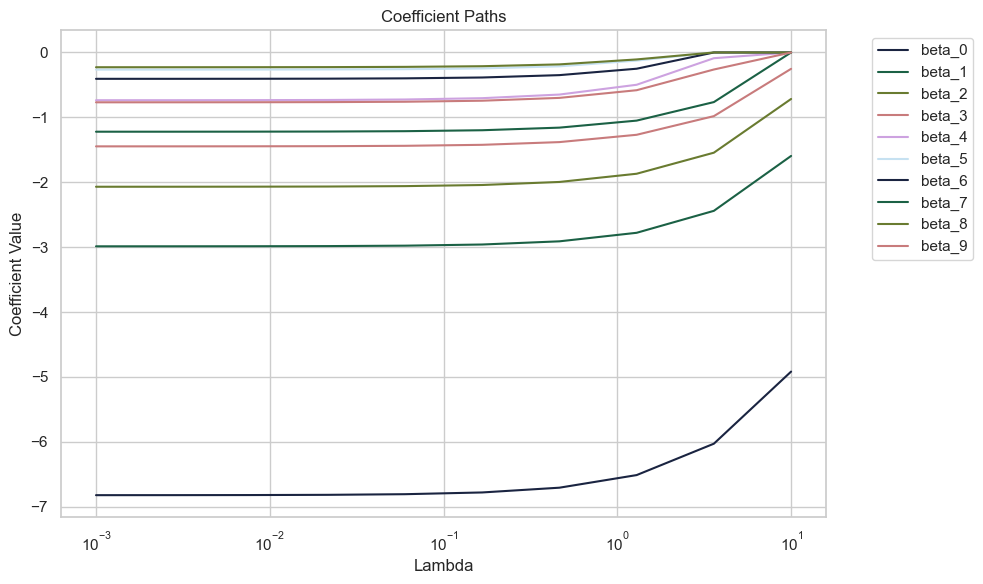

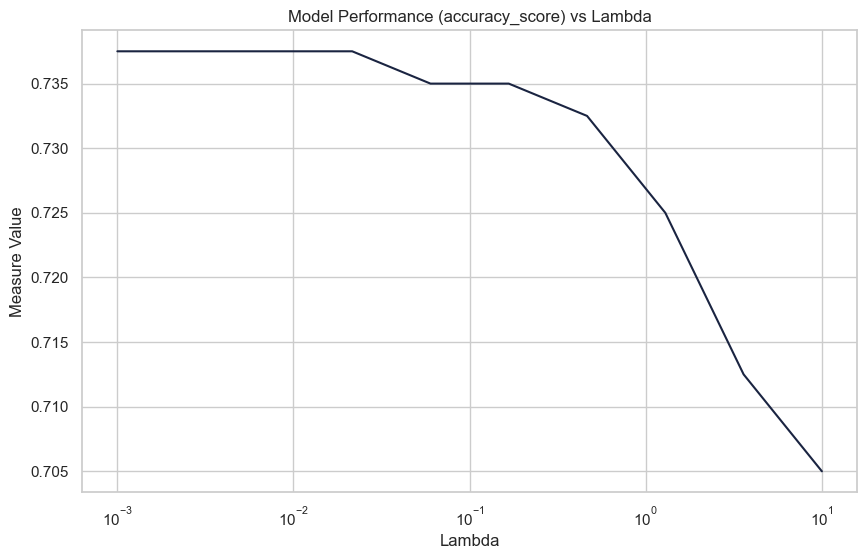

In [54]:
logRegCCD = LogRegCCD()

test_case = {
    "p": 0.5,
    "n": 2000,
    "d": 10,
    "g": 0.1,
}

data = SyntheticDataset(test_case["p"], test_case["n"], test_case["d"], test_case["g"])

X_train, X_test, y_train, y_test = train_test_split(
    data.X, data.y, test_size=0.2, random_state=42
)

logRegCCD.fit(X_train, y_train)

logRegCCD.plot_coefficients()

logRegCCD.plot(accuracy_score, X_test, y_test)

In [43]:
# parameters = {
#     "p": [0.5, 0.3, 0.4, 0.6, 0.7, 0.8],
#     "n": [2000, 5000, 10000],
#     "d": [10, 2, 4, 6, 20, 50],
#     "g": [0.3, 0.1, 0.5, 0.7, 0.9],
# }

parameters = {
    "p": [0.3, 0.4, 0.5, 0.6, 0.7],
    "n": [1000, 2000, 3000],
    "d": [5, 7, 10, 15],
    "g": [0.1, 0.3, 0.5, 0.7, 0.9],
}

# test_cases = create_test_cases(parameters)

test_cases = create_test_cases_all_combinations(parameters)

In [44]:
%%time

# TODO: Performance and Comparison according to the Project Task

# I think it is not needed to check every combination, if we just set all other parameters to constant and loop over current paramters
# it should be enough to examine its effects on the model performance

results = []
seeds = [
    CONST_RANDOM_SEED,
    CONST_RANDOM_SEED + 10,
    CONST_RANDOM_SEED + 20,
    CONST_RANDOM_SEED + 30,
    CONST_RANDOM_SEED + 40,
]

metrics = [accuracy_score, precision_score, recall_score, f1_score, roc_auc_score]

for test_case in test_cases:
    perform_experiment(test_case, results, seeds, metrics)

c:\Users\prusw\Documents\Repos\ccg-logistic-regression\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\prusw\Documents\Repos\ccg-logistic-regression\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


CPU times: total: 1h 12min 31s
Wall time: 1h 14min 32s


In [45]:
CONST_RESULTS_FILE_NAME = "results.csv"

In [46]:
results_df = pd.DataFrame(results)
results_df.to_csv(
    f"{CONST_RESULTS_DIRECTORY_PATH}/{CONST_RESULTS_FILE_NAME}", index=False
)

In [47]:
del results_df
del results
gc.collect()

617

In [48]:
results_df = pd.read_csv(f"{CONST_RESULTS_DIRECTORY_PATH}/{CONST_RESULTS_FILE_NAME}")

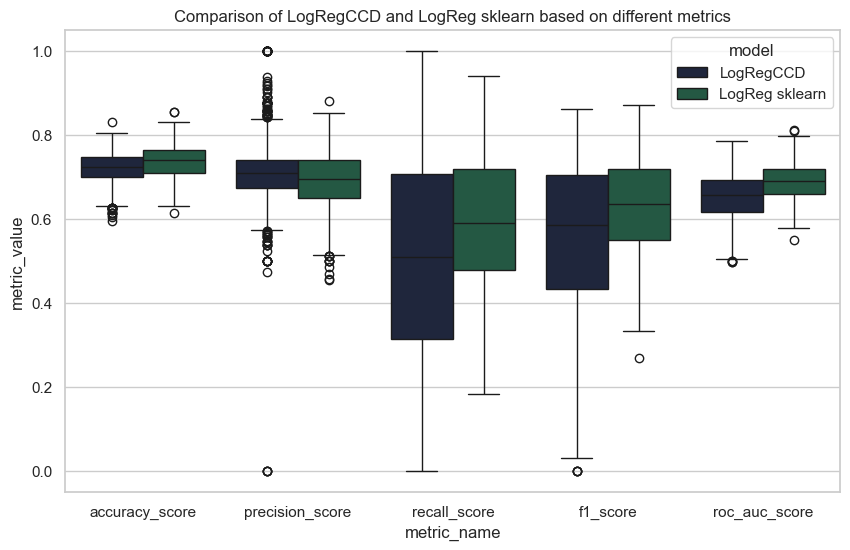

In [49]:
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=results_df,
    x="metric_name",
    y="metric_value",
    hue="model",
)
plt.title(f"Comparison of LogRegCCD and LogReg sklearn based on different metrics")
plt.savefig(f"{CONST_RESULTS_DIRECTORY_PATH}/comparison.png")
plt.show()

In [50]:
results_df.head()

,p,n,d,g,metric_value,metric_name,model,seed
0,0.3,1000,5,0.1,0.755000,accuracy_score,LogRegCCD,42
1,0.3,1000,5,0.1,0.636364,precision_score,LogRegCCD,42
2,0.3,1000,5,0.1,0.134615,recall_score,LogRegCCD,42
3,0.3,1000,5,0.1,0.222222,f1_score,LogRegCCD,42
4,0.3,1000,5,0.1,0.553794,roc_auc_score,LogRegCCD,42


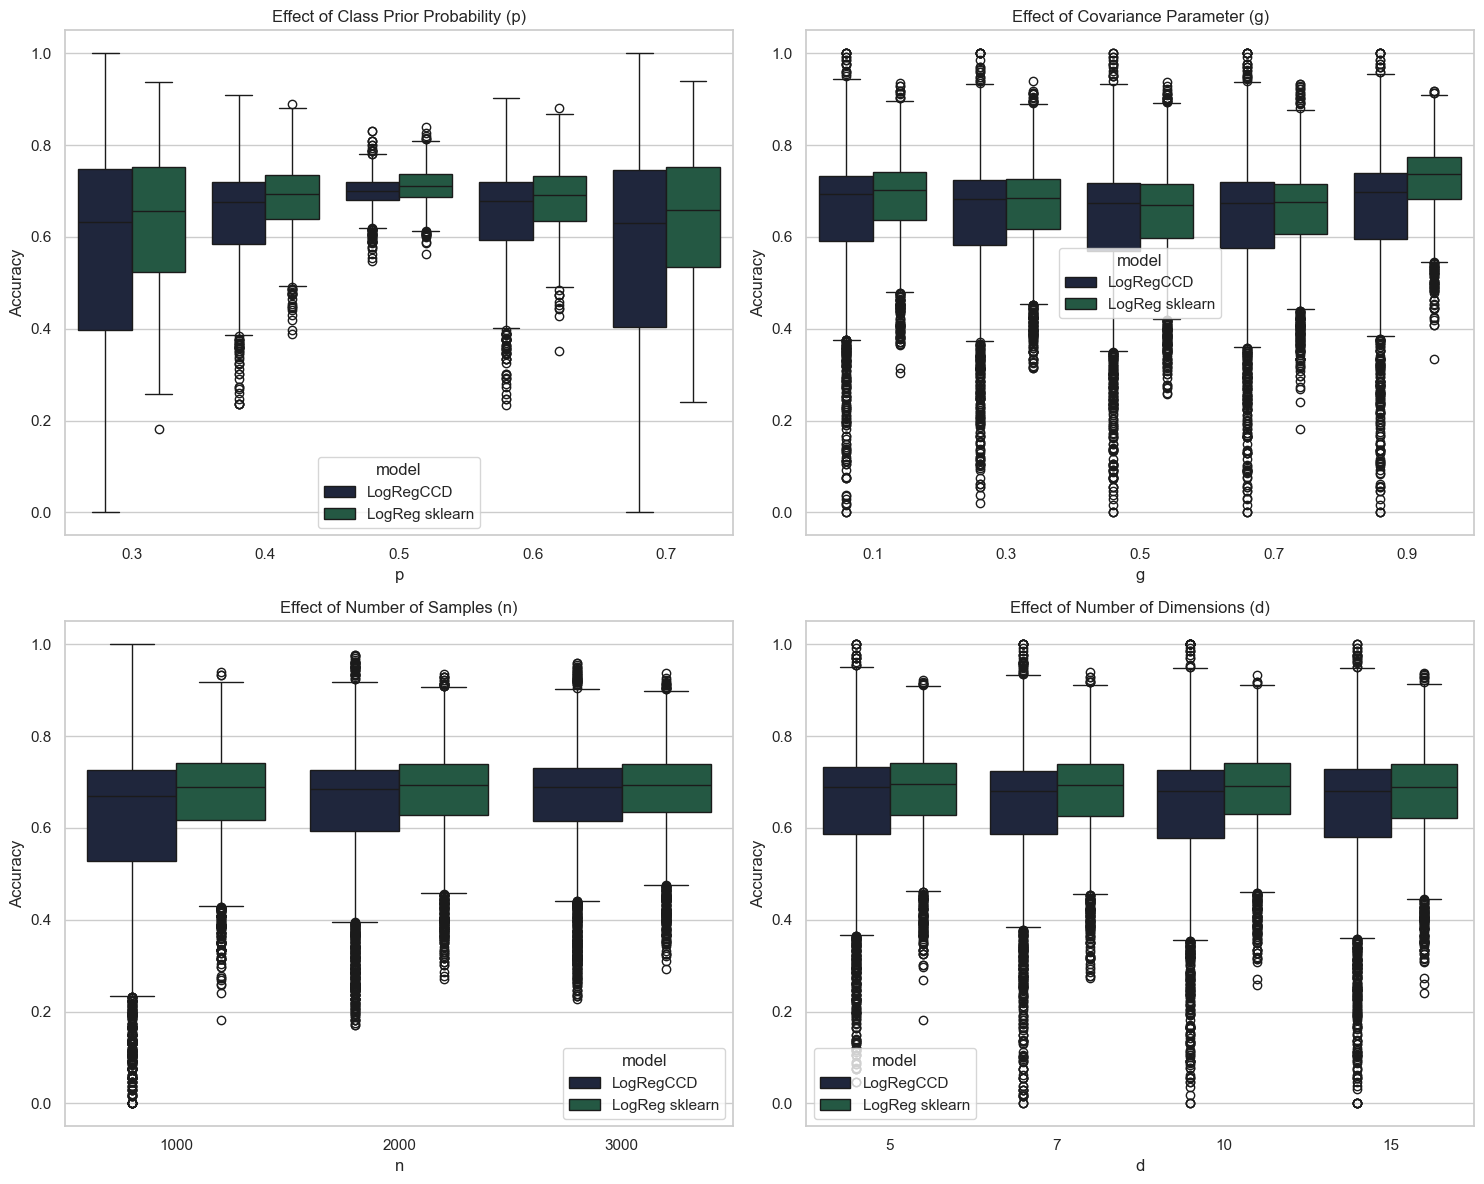


Effect of p:
                     count      mean       std       min       25%       50%  \
p   model                                                                      
0.3 LogReg sklearn  1500.0  0.637686  0.144697  0.181818  0.524238  0.656369   
    LogRegCCD       1500.0  0.578864  0.227503  0.000000  0.396825  0.631628   
0.4 LogReg sklearn  1500.0  0.682151  0.078192  0.388889  0.638170  0.693333   
    LogRegCCD       1500.0  0.650024  0.112320  0.236559  0.584821  0.677157   
0.5 LogReg sklearn  1500.0  0.711843  0.038418  0.563830  0.687226  0.710000   
    LogRegCCD       1500.0  0.699051  0.036059  0.547368  0.679803  0.700000   
0.6 LogReg sklearn  1500.0  0.681413  0.073210  0.350649  0.633929  0.691651   
    LogRegCCD       1500.0  0.650723  0.108106  0.233766  0.592751  0.678191   
0.7 LogReg sklearn  1500.0  0.640845  0.143412  0.240741  0.534552  0.659480   
    LogRegCCD       1500.0  0.578618  0.225314  0.000000  0.404739  0.630028   

                         

In [51]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

sns.boxplot(data=results_df, x="p", y="metric_value", hue="model", ax=ax1)
ax1.set_title("Effect of Class Prior Probability (p)")
ax1.set_ylabel("Accuracy")

sns.boxplot(data=results_df, x="g", y="metric_value", hue="model", ax=ax2)
ax2.set_title("Effect of Covariance Parameter (g)")
ax2.set_ylabel("Accuracy")

sns.boxplot(data=results_df, x="n", y="metric_value", hue="model", ax=ax3)
ax3.set_title("Effect of Number of Samples (n)")
ax3.set_ylabel("Accuracy")

sns.boxplot(data=results_df, x="d", y="metric_value", hue="model", ax=ax4)
ax4.set_title("Effect of Number of Dimensions (d)")
ax4.set_ylabel("Accuracy")

plt.tight_layout()
plt.savefig(f"{CONST_RESULTS_DIRECTORY_PATH}/parameter_effects.png")
plt.show()


for param in ["p", "n", "d", "g"]:
    print(f"\nEffect of {param}:")
    print(results_df.groupby([param, "model"])["metric_value"].describe())